In [1]:
import gensim
import numpy as np
import pandas as pd
import sys, time, os, warnings 
from collections import Counter 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import torchvision.models as models
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
# pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.1-cp36-cp36m-win_amd64.whl
# pip3 install torchvision

C:\Users\antoi\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load Data

In [2]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "./Data/Flicker8k_Dataset/train/"
## The location of the caption file
dir_Flickr_text = "./data/Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [3]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

Using TensorFlow backend.


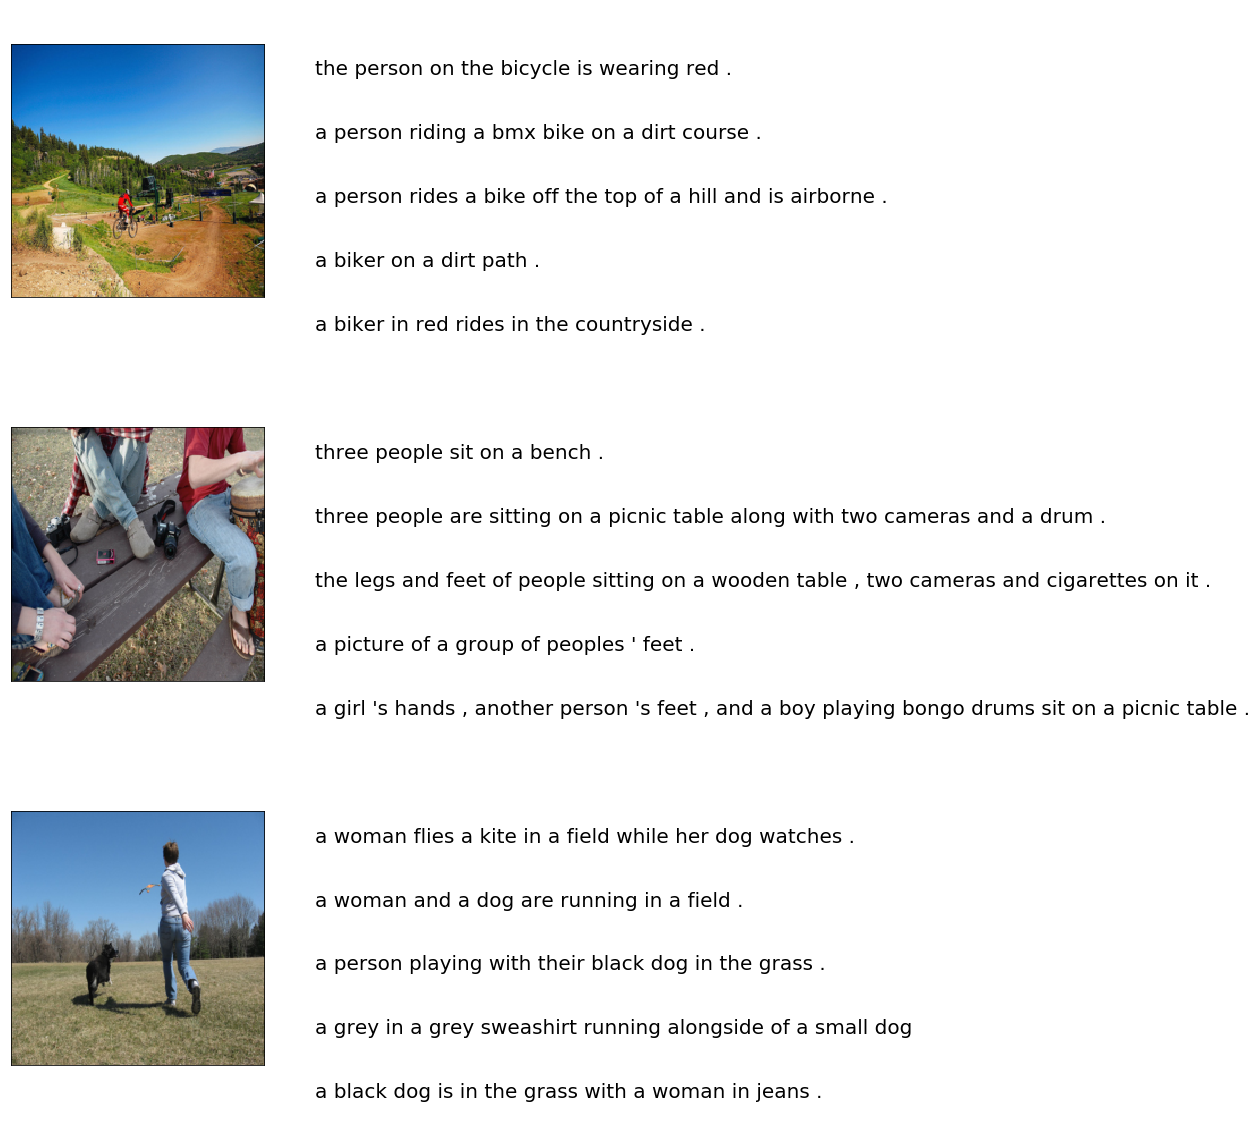

In [4]:
from keras.preprocessing.image import load_img, img_to_array

npix = 224
target_size = (npix,npix,3)

def get_random_pictures(n_pictures):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=n_pictures)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        image_load = load_img(filename, target_size=target_size)

        ax = fig.add_subplot(n_pictures,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(n_pictures,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
get_random_pictures(3)

# Sentence Processing 

In [5]:
def get_sentence_embedding(sentence, model):
    embeddings = np.array([model.word_vec(word) for word in sentence.split() if word in model.wv.vocab.keys()])
    return np.sum(embeddings.T,axis=1)

In [6]:
text_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300-SLIM.bin', binary=True)  

In [7]:
test = get_sentence_embedding('This is a test', text_model)

# Image Processing 

In [8]:
image_model = models.resnet18(pretrained=True)

In [9]:
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for param in image_model.parameters():
    param.requires_grad = False
image_model = image_model.to(device)

In [10]:
plt.ion()   # interactive mode

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './Data/Flicker8k_Dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, ""),
                                          data_transforms[x])
                  for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}

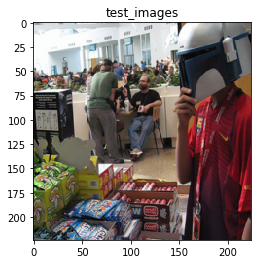

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="test_images")

In [12]:
for i, (inputs, labels) in enumerate(dataloaders['train']):
    inputs = inputs.to(device)
    print(inputs.shape)
    print(image_model(inputs).shape)
    break

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


In [13]:
def get_random_data(batch_size):
    for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=batch_size)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        random_caption = captions[np.random.randint(0,len(captions))]
        image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)[np.newaxis, :]
        return image_model(torch.from_numpy(image)), get_sentence_embedding(random_caption, text_model)

In [14]:
get_random_data(1)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 333, 500, 3] to have 3 channels, but got 333 channels instead

In [ ]:
batch_size = 1
for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=batch_size)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        random_caption = captions[np.random.randint(0,len(captions))]
        image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)[np.newaxis, :].swapaxes(2,3).swapaxes(1,2)
        print(image_model(torch.from_numpy(image)), get_sentence_embedding(random_caption, text_model))

In [44]:
image.swapaxes(2,3).swapaxes(1,2).shape,image.shape

((1, 3, 333, 500), (1, 333, 500, 3))

In [31]:
image.shape

(1, 333, 500, 3)

In [39]:
image[0,:,:,:].shape

(333, 500, 3)

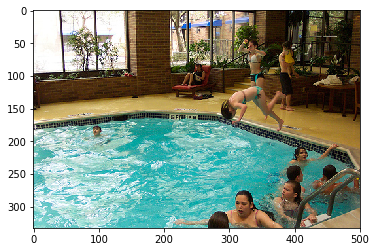

In [40]:
plt.imshow(image[0,:,:,:])